# Les réseaux convolutionnels

Réseau inspiré de http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

## 1. Importation des librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## pour que les résultats soient reproductibles
#from numpy.random import seed
#seed(1)
#from tensorflow import set_random_seed
#set_random_seed(1)

## 2. Chargement et conditionnement des données d'apprentissage

Chargement et normalisation des données

In [28]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
print(f"La dimension de la base de données d'entrainement : {train_images.shape}")
print(f"La dimension de la base de données de test : {test_images.shape}")
print(f"Les différentes classe {np.unique(test_images)}")

La dimension de la base de données d'entrainement : (60000, 28, 28)
La dimension de la base de données de test : (10000, 28, 28)
Les différentes classe [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 

Affichage de quelques images 

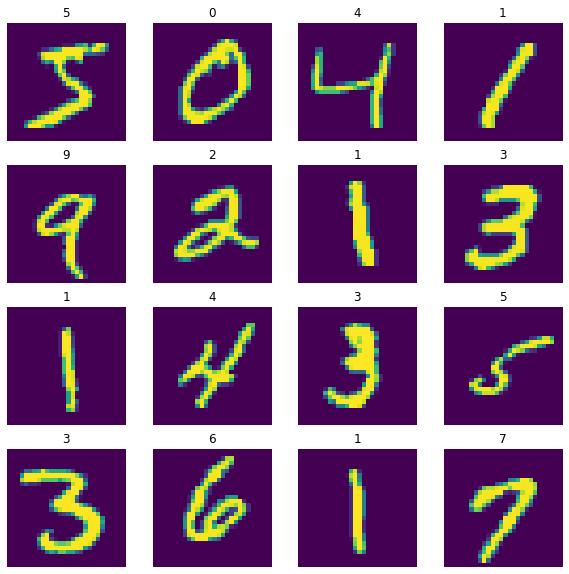

In [29]:
import cv2
total_rows = total_cols = 4
fig, axes = plt.subplots(total_rows, total_cols, figsize=(10, 10))
for img, lab, ax in zip(train_images, train_labels, list(axes.flat)):
    ax.imshow(img)
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'{lab}')

Pour les CNN : On rajoute une dimension pour spécifier qu'il s'agit d'imgages en NdG

In [30]:
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)
print(f"La dimension de la base de données d'entrainement : {train_images.shape}")
print(f"La dimension de la base de données de test : {test_images.shape}")

La dimension de la base de données d'entrainement : (60000, 28, 28, 1)
La dimension de la base de données de test : (10000, 28, 28, 1)


One hot encoding

In [31]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(f"La dimension de labels de la base de données d'entrainement : {train_labels.shape}")
print(f"La dimension de labesl de la base de données de test : {test_labels.shape}")

La dimension de labels de la base de données d'entrainement : (60000, 10)
La dimension de labesl de la base de données de test : (10000, 10)


## 3. Architecture du réseau 

Concevoir un réseau inspiré LeNet5 http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
![LeNet5](https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)


La structure globale sera conservée (nombre de couches, nombre de neurones par couche…) mais dans cette version :
- Les couches de convolution sont totalement connectées
- La sortie est une couche fully connected (FC) classique 
- La fonction de coût est l’entropie croisée


In [32]:
filter_size_conv1 = (5,5)

## Définition de l'architecture du modèle
mnist_model = tf.keras.models.Sequential()
# Expliquez à quoi correspondent les valeurs numériques qui définissent les couches du réseau
mnist_model.add(tf.keras.layers.Conv2D(filters=6,kernel_size=filter_size_conv1,padding="same", activation='tanh', input_shape=(28, 28, 1)))
mnist_model.add(tf.keras.layers.AveragePooling2D())
mnist_model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),padding="valid", activation='tanh'))
mnist_model.add(tf.keras.layers.AveragePooling2D())
mnist_model.add(tf.keras.layers.Flatten())
mnist_model.add(tf.keras.layers.Dense(120 , activation='tanh'))
#mnist_model.add(tf.keras.layers.Dropout(0.5))
mnist_model.add(tf.keras.layers.Dense(84 , activation='tanh'))
mnist_model.add(tf.keras.layers.Dense(10 , activation='softmax'))

# expliquer le nombre de paramètre de ce réseau
print(mnist_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)              

(5, 5, 1, 6)


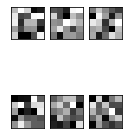

In [34]:
sgd = tf.keras.optimizers.Adam()

mnist_model.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])

def displayConvFilers(model, layer_name, num_filter=4, filter_size=(3,3), num_channel=0, fig_size=(2,2)):
    '''
    model : le réseau de neurone dont on souhaite visualiser les filtres
    nb_filter : le nombre de filtre que l'on souhaite visualiser
    filter size : la taille des filtres de la couche
    num_channel : le numéro du canal que l'on souaite visualiser 
    fig_size : les dimensions de la figure. Doivent être en cohérence avec nb_filter
    '''
    
    layer_dict = dict([(layer.name, layer) for layer in mnist_model.layers])
    
    weight, biais = layer_dict[layer_name].get_weights()
    print(weight.shape) 
    plt.figure(figsize=fig_size)
    for i in range(num_filter):
        plt.subplot(fig_size[0],fig_size[1],i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        vis = np.reshape(weight[:,:,num_channel,i],filter_size)
        plt.imshow(vis, cmap=plt.cm.binary)
    plt.show()

# On visualise avant l'entrainement
displayConvFilers(  mnist_model, 'conv2d', 
                    num_filter=6, 
                    filter_size=filter_size_conv1, 
                    num_channel=0, 
                    fig_size=(2,3)
                )


## 4. Apprentissage du réseau

In [35]:
mnist_model.fit(train_images,
         train_labels,
         batch_size=64,
         epochs=20
         )

Epoch 1/20
938/938 [==============================] - 11s 11ms/step - loss: 0.2641 - accuracy: 0.9228
Epoch 2/20
938/938 [==============================] - 10s 11ms/step - loss: 0.1027 - accuracy: 0.9685
Epoch 3/20
938/938 [==============================] - 19s 21ms/step - loss: 0.0703 - accuracy: 0.9785
Epoch 4/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0514 - accuracy: 0.9842
Epoch 5/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0414 - accuracy: 0.9870
Epoch 6/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0320 - accuracy: 0.9900
Epoch 7/20
938/938 [==============================] - 16s 17ms/step - loss: 0.0276 - accuracy: 0.9909
Epoch 8/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0229 - accuracy: 0.9926
Epoch 9/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0192 - accuracy: 0.9944
Epoch 10/20
938/938 [==============================] - 14s 15ms/step - loss: 0.016

## 5. Evaluation du modèle sur la base de test

In [36]:
## Evaluation du modèle 
test_loss, test_acc = mnist_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


313/313 [==============================] - 2s 4ms/step - loss: 0.0594 - accuracy: 0.9843
Test accuracy: 0.9843000173568726


## 6. Visualisation des filtres appris prar me réseau

Compléter la fonction de visualisation des filtres suivante :

(5, 5, 1, 6)


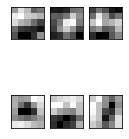

In [37]:
# On visualise apres l'entrainement
displayConvFilers(  mnist_model, 'conv2d', 
                    num_filter=6, 
                    filter_size=filter_size_conv1, 
                    num_channel=0, 
                    fig_size=(2,3)
                )


Appeler deux fois la fonction pour afficher des filtres de la première couche et des filtres de la deuxième couche de convolution

(5, 5, 1, 6)


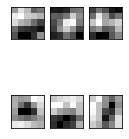

(5, 5, 6, 16)


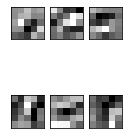

In [42]:
# On visualise avant l'entrainement
displayConvFilers(  mnist_model, 'conv2d', 
                    num_filter=6, 
                    filter_size=filter_size_conv1, 
                    num_channel=0, 
                    fig_size=(2,3)
                )

# On visualise avant l'entrainement
displayConvFilers(  mnist_model, 'conv2d_1', 
                    num_filter=6, 
                    filter_size=filter_size_conv1, 
                    num_channel=0, 
                    fig_size=(2,3)
                )
